In [ ]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install scikit-learn pillow torchvision opencv-python
!pip install torch tqdm  matplotlib seaborn
!pip install evaluate
!pip install datasets accelerate transformers scikit-learn pillow torchvision opencv-python torch tqdm matplotlib seaborn evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# %%
!pip install datasets accelerate transformers scikit-learn pillow torchvision opencv-python torch tqdm matplotlib seaborn evaluate

# %%
import os
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from evaluate import load
import pandas as pd
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from tqdm import tqdm
import seaborn as sns


In [ ]:
# %%
# Dataset directory (change to your path or mount drive)
DATA_ROOT_DIR = "/content/drive/MyDrive/apple_split/apple_split"
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VAL_DIR = os.path.join(DATA_ROOT_DIR, 'val')
TEST_DIR = os.path.join(DATA_ROOT_DIR, 'test')


In [ ]:
# %%
# Define your dataset class
class AppleDiseaseDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Return a dictionary for easier handling by the Trainer and collate_fn
        return {'image': image, 'label': label}

# %%
# Define your transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Example normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Example normalization
])

In [ ]:
# %%
# Load datasets
train_dataset = AppleDiseaseDataset(TRAIN_DIR, transform=train_transform)
val_dataset = AppleDiseaseDataset(VAL_DIR, transform=val_test_transform)
test_dataset = AppleDiseaseDataset(TEST_DIR, transform=val_test_transform)

# You can optionally check the number of samples and classes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

# %%
# Example of creating DataLoaders (you would use these for visualization, not directly for Trainer)
# The Trainer uses the raw datasets and the collate_fn
batch_size = 32
train_dataloader_viz = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader_viz = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader_viz = DataLoader(test_dataset, batch_size=batch_size)

Number of training samples: 1177
Number of validation samples: 148
Number of test samples: 144
Number of classes: 4
Classes: ['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
# %%
# Gather all the label names in a list and define num_labels
label_names = train_dataset.classes
num_labels = len(label_names)

print(f"Label names: {label_names}")
print(f"Number of labels: {num_labels}")

Label names: ['healthy', 'multiple_diseases', 'rust', 'scab']
Number of labels: 4


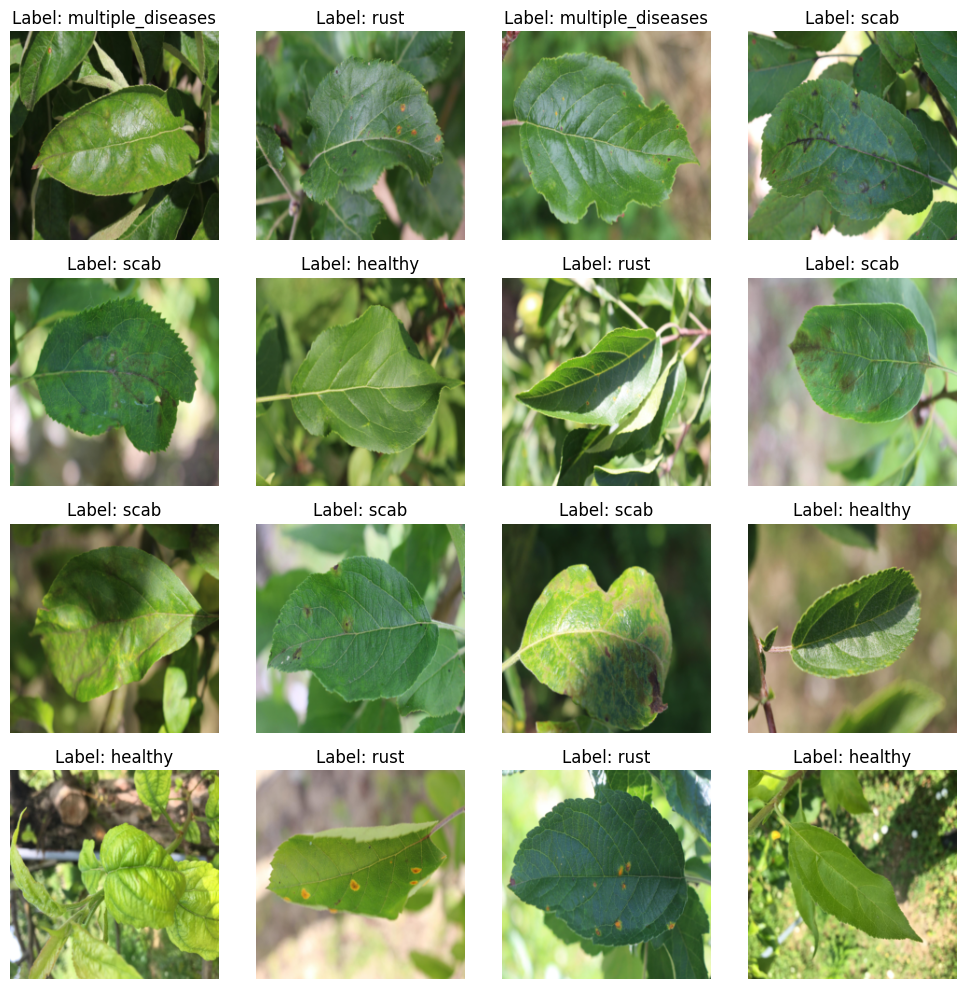

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# %%
def create_sample_grid(rows=4, cols=4):
    num_images = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten() # Flatten the axes array for easier iteration

    # Get a batch of images and labels from the training dataloader for visualization
    data_batch = next(iter(train_dataloader_viz))
    images = data_batch['image'] # Get images from the dictionary
    labels = data_batch['label'] # Get labels from the dictionary

    # Convert the images back to a format suitable for plotting
    # Permute dimensions from (C, H, W) to (H, W, C) and unnormalize
    images = images.permute(0, 2, 3, 1).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1) # Clip values to be within [0, 1]

    # Iterate through the images and plot them in the grid
    for i in range(min(num_images, len(images))): # Ensure we don't exceed the number of images in the batch
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(f"Label: {label_names[labels[i].item()]}") # Get the label value
        ax.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

create_sample_grid(rows=4, cols=4)

# %%
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

# %%
VIT_MODEL_NAME = 'google/vit-base-patch16-224-in21k'
processor = AutoImageProcessor.from_pretrained(VIT_MODEL_NAME)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

In [ ]:
# Define the collate function for the Trainer
def collate_fn(batch):
    # 'batch' is a list of dictionaries from the custom dataset
    # Access the image data using the key 'image' and labels using the key 'label'
    pixel_values = torch.stack([x['image'] for x in batch])
    labels = torch.tensor([x['label'] for x in batch])

    # The Trainer expects the image data to be named 'pixel_values'
    # and labels to be named 'labels' or 'label_ids'.
    # Renaming 'image' to 'pixel_values' here aligns with the Trainer's expectations.
    return {
        'pixel_values': pixel_values,
        'labels': labels # Or 'label_ids': labels, but 'labels' is also commonly used.
    }

# Define the compute_metrics function
def compute_metrics(eval_pred):
    # eval_pred is an EvalPrediction object which contains predictions and label_ids
    predictions, labels = eval_pred
    # Use numpy to get the predicted class indices by finding the maximum along axis 1
    predictions = np.argmax(predictions, axis=1)
    # Calculate accuracy using the accuracy_score function from sklearn.metrics
    return {"accuracy": accuracy_score(labels, predictions)}


# Define your model
model = ViTForImageClassification.from_pretrained(
    VIT_MODEL_NAME,
    num_labels=num_labels, # num_labels is now defined
    id2label={str(i): c for i, c in enumerate(label_names)}, # label_names is now defined
    label2id={c: str(i) for i, c in enumerate(label_names)}, # label_names is now defined
    ignore_mismatched_sizes=True
)

model.to(device)

# Define your training arguments
out_dir = "/content/drive/MyDrive/apple_split/training_output"
training_args = TrainingArguments(
  output_dir=out_dir,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  eval_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=20,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn, # Use your custom collate function
    compute_metrics=compute_metrics, # compute_metrics is now defined
    train_dataset=train_dataset, # Use your custom train_dataset
    eval_dataset=val_dataset,   # Use your custom val_dataset
    # processor is generally used for preprocessing images before passing them to the model.
    # Since your custom dataset and transforms handle this, you don't pass it to the Trainer.
    # processor=processor,
)

save_dir = '/content/drive/MyDrive/apple_split/out/best_model'  # Path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # here we are saving the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.345494,0.912162
2,No log,0.331517,0.891892
3,No log,0.299193,0.912162
4,No log,0.374590,0.912162
5,No log,0.328514,0.925676
6,No log,0.293332,0.932432
7,0.164000,0.343036,0.939189
8,0.164000,0.348161,0.925676
9,0.164000,0.333803,0.932432
10,0.164000,0.350162,0.932432


***** train metrics *****
  epoch                    =         20.0
  total_flos               = 1698913177GF
  train_loss               =       0.0571
  train_runtime            =   0:26:36.52
  train_samples_per_second =       14.744
  train_steps_per_second   =        0.927


In [ ]:
# prompt: metrics = trainer.evaluate(prepared_ds['test']) trainer.log_metrics("test", metrics) trainer.save_metrics("test", metrics)
# make changes with my current code

metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** test metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9236
  eval_loss               =     0.2602
  eval_runtime            = 0:01:10.14
  eval_samples_per_second =      2.053
  eval_steps_per_second   =      0.128


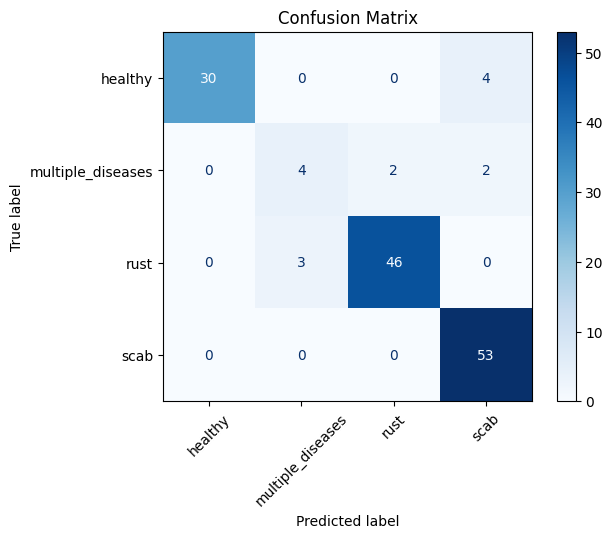

Classification Report:
                   precision    recall  f1-score   support

          healthy      1.000     0.882     0.938        34
multiple_diseases      0.571     0.500     0.533         8
             rust      0.958     0.939     0.948        49
             scab      0.898     1.000     0.946        53

         accuracy                          0.924       144
        macro avg      0.857     0.830     0.841       144
     weighted avg      0.925     0.924     0.922       144



In [ ]:
test_results = trainer.predict(test_dataset)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Let's Calculate and display Precision, Recall, and F1 Score
from sklearn.metrics import classification_report

# Generate the classification report for results
report = classification_report(y_true, y_pred, target_names=label_names, digits=3)

# Print the report
print("Classification Report:")
print(report)

In [14]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os

# Assuming 'out_dir' is defined from your previous code execution
log_history_path = os.path.join(out_dir, 'trainer_state.json')

if os.path.exists(log_history_path):
    with open(log_history_path, 'r') as f:
        trainer_state = json.load(f)
        log_history = trainer_state.get('log_history', [])

    epochs = []
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for entry in log_history:
        if 'loss' in entry:
            epochs.append(entry['epoch'])
            train_losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracies.append(entry['eval_accuracy'])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
    eval_epochs = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]
    plt.plot(eval_epochs, eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, eval_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("trainer_state.json not found. Cannot plot loss curves.")

trainer_state.json not found. Cannot plot loss curves.


In [15]:
out_dir = "/content/drive/MyDrive/apple_split/training_output"

trainer_state.json not found. Attempting to use trainer.state.log_history.


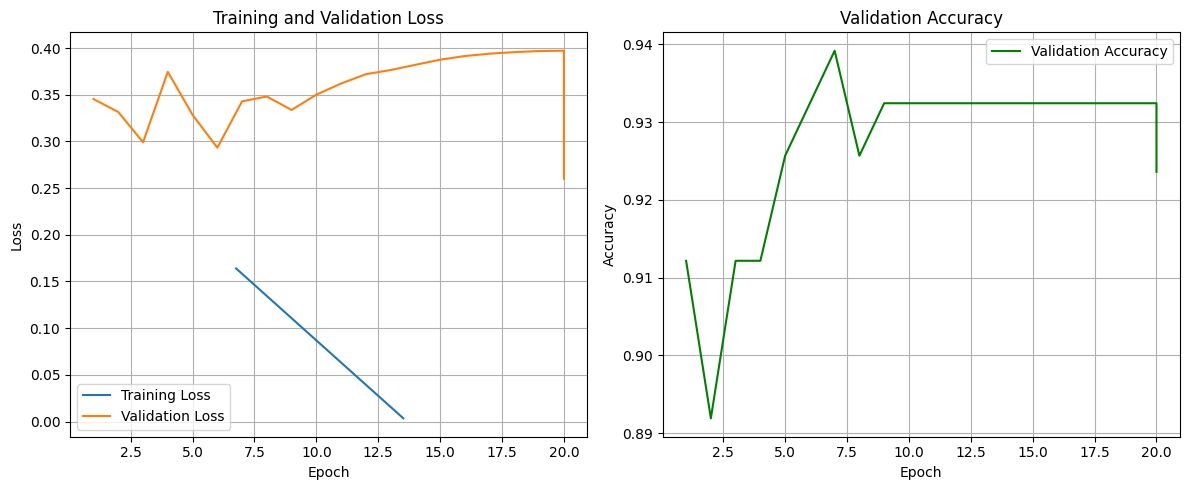

In [16]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os

# Assuming 'out_dir' is defined from your previous code execution

log_history_path = os.path.join(out_dir, 'trainer_state.json')

log_history = []

# Try loading from file first
if os.path.exists(log_history_path):
    try:
        with open(log_history_path, 'r') as f:
            trainer_state = json.load(f)
            log_history = trainer_state.get('log_history', [])
    except Exception as e:
        print(f"Error loading trainer_state.json: {e}")
        print("Attempting to use trainer.state.log_history instead.")
        # Fallback to trainer.state.log_history if file loading fails
        if 'trainer' in locals() and hasattr(trainer, 'state'):
            log_history = trainer.state.log_history
else:
    print("trainer_state.json not found. Attempting to use trainer.state.log_history.")
    # Fallback to trainer.state.log_history if file not found
    if 'trainer' in locals() and hasattr(trainer, 'state'):
        log_history = trainer.state.log_history

if log_history:
    epochs = []
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for entry in log_history:
        if 'loss' in entry:
            epochs.append(entry['epoch'])
            train_losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracies.append(entry['eval_accuracy'])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure consistent length for plotting
    plot_epochs_train = epochs[:len(train_losses)]
    plt.plot(plot_epochs_train, train_losses, label='Training Loss')

    eval_epochs = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]
    plt.plot(eval_epochs, eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, eval_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Log history is empty. Cannot plot loss curves.")

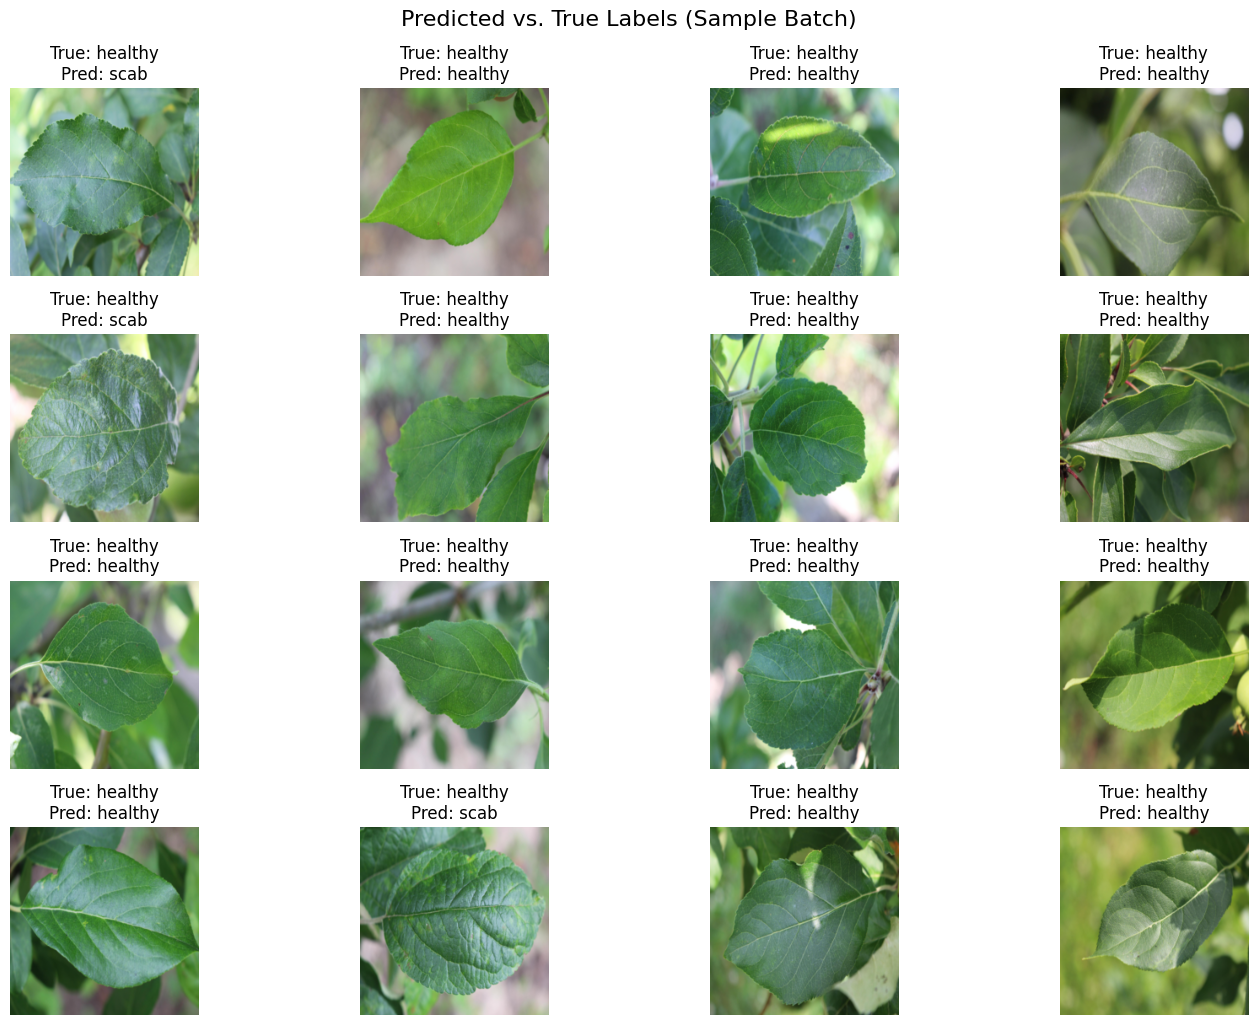

In [18]:
# Assuming 'test_dataloader_viz' and 'label_names' are defined

# Get a batch of images and labels from the test dataloader
data_batch = next(iter(test_dataloader_viz))
images = data_batch['image']
true_labels = data_batch['label']

# Move images to the device the model is on for prediction
images = images.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(pixel_values=images)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

# Move images and labels back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
true_labels = true_labels.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()

# Unnormalize images for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = std * images + mean
images = np.clip(images, 0, 1)

# Plot a sample of images with true and predicted labels
num_images_to_show = 16  # You can adjust this
plt.figure(figsize=(15, 10))
for i in range(min(num_images_to_show, len(images))):
    plt.subplot(4, 4, i + 1) # Adjust subplot grid
    plt.imshow(images[i])
    plt.title(f"True: {label_names[true_labels[i]]}\nPred: {label_names[predicted_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Predicted vs. True Labels (Sample Batch)", y=1.02, fontsize=16)
plt.show()

<ipython-input-19-82ab223e48df>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=class_accuracies, palette='viridis')


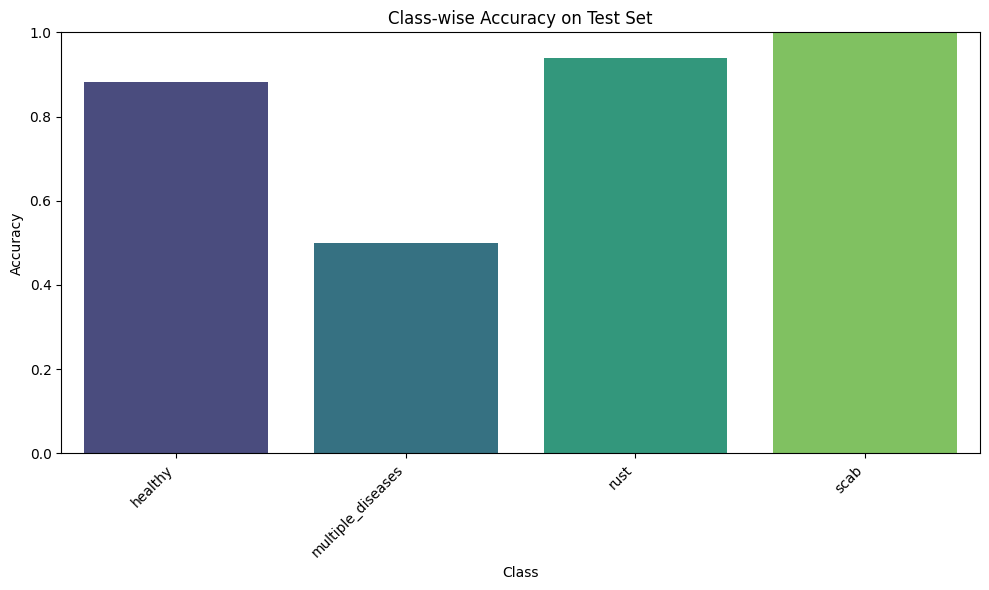

In [19]:
# Assuming 'y_true' and 'y_pred' are defined from the test set predictions
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_names, y=class_accuracies, palette='viridis')
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy on Test Set")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.tight_layout()
plt.show()

<ipython-input-21-04ebf05621b5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y='precision', data=report_df, ax=axes[0], palette='viridis')
<ipython-input-21-04ebf05621b5>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y='recall', data=report_df, ax=axes[1], palette='viridis')
<ipython-input-21-04ebf05621b5>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y='f1-score', data=report_df, ax=axes[2], palette='viridis')


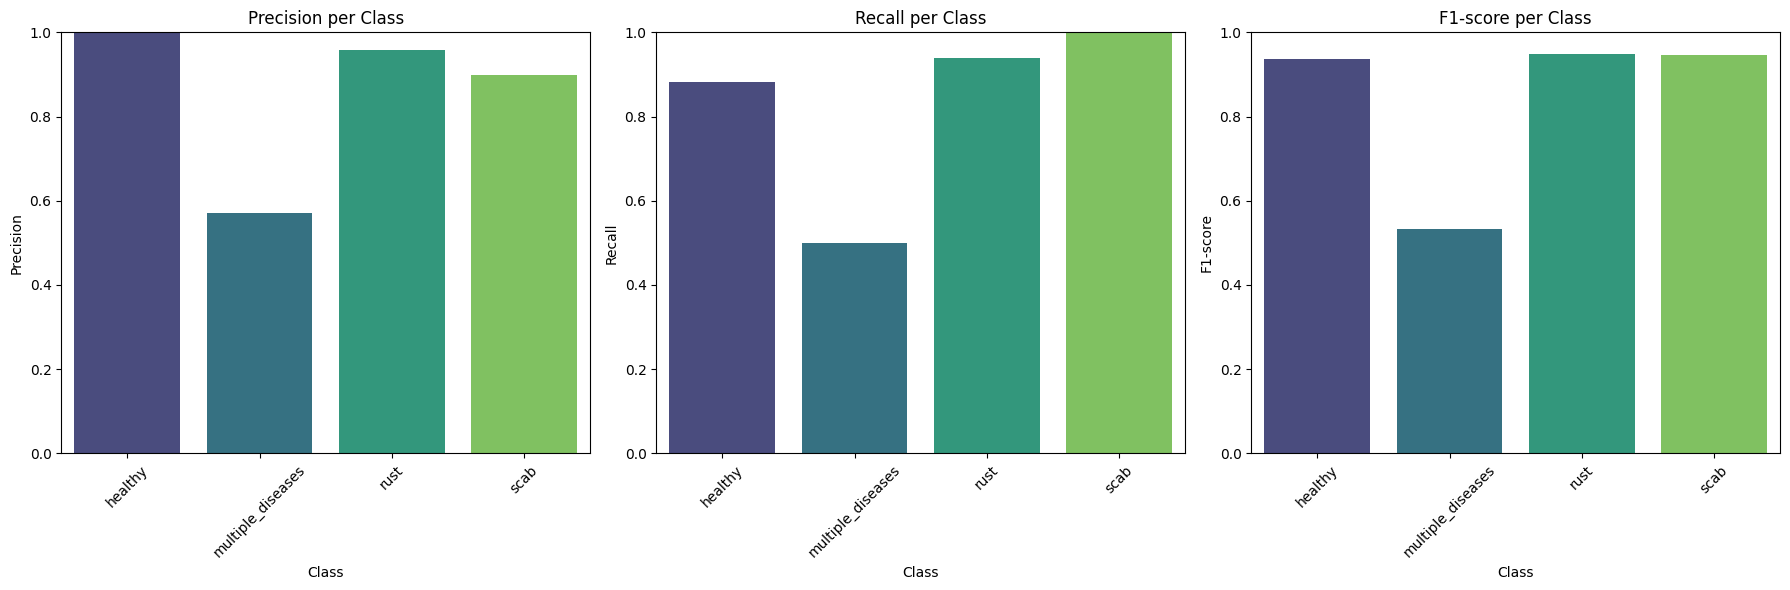

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Assuming 'y_true' and 'y_pred' are defined from the test set predictions
# Assuming 'label_names' is defined

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Convert the report to a pandas DataFrame for easier plotting
report_df = pd.DataFrame(report).transpose()

# Remove the 'accuracy', 'macro avg', and 'weighted avg' rows for class-wise plot
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Plot the classification report metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision
sns.barplot(x=report_df.index, y='precision', data=report_df, ax=axes[0], palette='viridis')
axes[0].set_title('Precision per Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# Plot Recall
sns.barplot(x=report_df.index, y='recall', data=report_df, ax=axes[1], palette='viridis')
axes[1].set_title('Recall per Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1)

# Plot F1-score
sns.barplot(x=report_df.index, y='f1-score', data=report_df, ax=axes[2], palette='viridis')
axes[2].set_title('F1-score per Class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

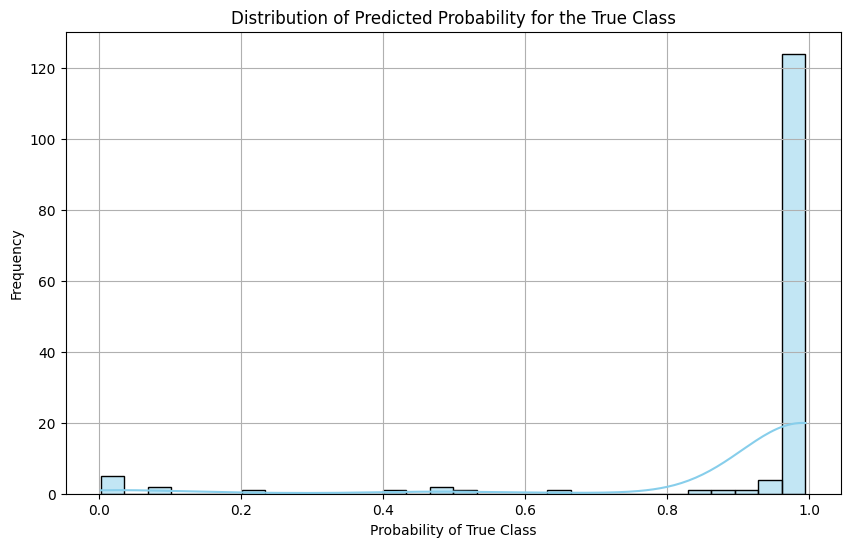

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Assuming 'test_results' contains the prediction logits
# test_results = trainer.predict(test_dataset)
# logits = test_results.predictions

# Apply softmax to get probabilities
probabilities = torch.softmax(torch.tensor(test_results.predictions), dim=1).numpy()

# Get the probability of the true class for each sample
true_class_probabilities = probabilities[np.arange(len(y_true)), y_true]

plt.figure(figsize=(10, 6))
sns.histplot(true_class_probabilities, bins=30, kde=True, color='skyblue')
plt.xlabel("Probability of True Class")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probability for the True Class")
plt.grid(True)
plt.show()

